In [10]:
import os
import sys
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from scipy.io.wavfile import read
import wave
from sklearn.model_selection import train_test_split
import librosa
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
import sounddevice as sd
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import  Conv1D, GRU, Dropout, Input, Dense, Conv2D, Reshape, MaxPooling2D
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from scipy import linalg
from pydub import AudioSegment
random.seed(111)
fs = 16000

#D:\Koulujutut\audio_project\training_data\car
#path = pathlib.Path().resolve()
#str(path.parents[0])}

car_train_data_path = f"../Project/audio_project_data/training_data/car/"
tram_train_data_path = f"../Project/audio_project_data/training_data/tram/"

car_val_data_path = f"../Project/audio_project_data/validation_data/car/"
tram_val_data_path = f"../Project/audio_project_data/validation_data/tram/"
 

In [11]:
for file in os.listdir(car_train_data_path):
        if file.endswith(".mp3"):
            print(os.path.join(car_train_data_path, file))
            audio = AudioSegment.from_mp3(os.path.join(car_train_data_path, file))
            wav_file = file.replace("mp3", "")
            audio.export(os.path.join(car_train_data_path, wav_file), format="wav")

for file in os.listdir(tram_train_data_path):
    if file.endswith(".mp3"):
        audio = AudioSegment.from_mp3(os.path.join(tram_train_data_path, file))
        wav_file = file.replace("mp3", "")
        audio.export(os.path.join(tram_train_data_path, wav_file), format="wav")

for file in os.listdir(car_val_data_path):
    if file.endswith(".mp3"):
        audio = AudioSegment.from_mp3(os.path.join(car_val_data_path, file))
        wav_file = file.replace("mp3", "")
        audio.export(os.path.join(car_val_data_path, wav_file), format="wav")

for file in os.listdir(tram_val_data_path):
    if file.endswith(".mp3"):
        audio = AudioSegment.from_mp3(os.path.join(tram_val_data_path, file))
        wav_file = file.replace("mp3", "")
        audio.export(os.path.join(tram_val_data_path, wav_file), format="wav")


In [12]:
def spec_augment(spec: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.10, time_masking_max_percentage=0.10):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec


In [13]:
car_train_data = []
tram_train_data = []
car_test_data = []
tram_test_data = []
car_val_data = []
tram_val_data = []
sample_rate = 16000
car_train_data_aug = []
tram_train_data_aug = []

car_audio = []
tram_audio = []
#The lenght of longest audio sample is defined here.
# For every audio sample zeros are added to make samples to be 
# in same size.
longest_sample = 125611



#audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))
for car in os.listdir(car_train_data_path):
    
    audio, fs = librosa.load(os.path.join(car_train_data_path, car), sr=16000)
    # if len(audio) > longest_sample:
    #     longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))
    car_audio.append(audio)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    car_train_data.append(mel_spec_db_norm) 
    

    mel_spec_db = librosa.power_to_db(spec_augment(mel_spec), ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    car_train_data_aug.append(mel_spec_db_norm) 



    
for car in os.listdir(car_val_data_path):
    audio, fs = librosa.load(os.path.join(car_val_data_path, car), sr=16000)
    
    #if len(audio) > longest_sample:
    #    longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    car_val_data.append(mel_spec_db_norm) 
    
    
    

for tram in os.listdir(tram_train_data_path):
    audio, fs = librosa.load(os.path.join(tram_train_data_path, tram), sr=16000)    
    
    # if len(audio) > longest_sample:
    #     longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))
        
    tram_audio.append(audio)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    tram_train_data.append(mel_spec_db_norm)

    
    mel_spec_db = librosa.power_to_db(spec_augment(mel_spec), ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    tram_train_data_aug.append(mel_spec_db_norm) 
    

    
for tram in os.listdir(tram_val_data_path):
    
    audio, fs = librosa.load(os.path.join(tram_val_data_path, tram), sr=16000)
    
    # if len(audio) > longest_sample:
    #    longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    tram_val_data.append(mel_spec_db_norm)

     




In [14]:
def time_shift(audio): 
    return np.roll(audio,int(sample_rate/(random.randint(2,10)))) 



for audio_first in car_audio:
        audio_shifted = time_shift(audio_first)*random.uniform(0.6, 0.9)
        mel_spec = librosa.feature.melspectrogram(y=audio_shifted, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
        mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
        car_train_data.append(mel_spec_db_norm) 
    

for audio_first in tram_audio:
        audio_shifted = np.add(audio_first, time_shift(audio_first)*random.uniform(0.6, 0.9))
        mel_spec = librosa.feature.melspectrogram(y=audio_shifted, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
        mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
        tram_train_data.append(mel_spec_db_norm)
        

car_train_data = car_train_data + car_train_data_aug
tram_train_data = tram_train_data + tram_train_data_aug

/tmp/ipykernel_36721/2080153835.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x)


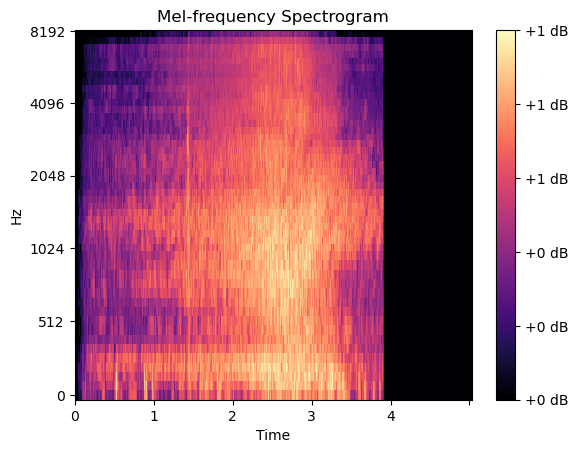

In [15]:
import librosa.display
fig, ax = plt.subplots()
x = ["","0", "1", "2", "3", "4"]

img = librosa.display.specshow(np.transpose(car_train_data[1]), x_axis='time',
y_axis='mel', sr=16000, fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set_xticklabels(x)
ax.set(title='Mel-frequency Spectrogram')
plt.savefig('mel_spec.png')

In [16]:
print(np.shape(car_train_data))
print(np.shape(tram_train_data))
print(np.shape(car_val_data))
print(np.shape(tram_val_data))

car_train_data = np.squeeze(car_train_data)
tram_train_data = np.squeeze(tram_train_data)
car_val_data = np.squeeze(car_val_data)
tram_val_data = np.squeeze(tram_val_data)

keyword_labels = np.ones(car_train_data.shape[0])
val_pos_labels = np.ones(car_val_data.shape[0])

noise_labels = 0*np.ones(tram_train_data.shape[0])
val_neg_labels = 0*np.ones(tram_val_data.shape[0])

X_train = np.concatenate((car_train_data, tram_train_data), axis=0)
y_train  = np.concatenate((keyword_labels, noise_labels), axis=0)

X_val = np.concatenate((car_val_data, tram_val_data), axis=0)
y_val = np.concatenate((val_pos_labels, val_neg_labels), axis=0)

y_train = tf.keras.utils.to_categorical(y_train, 2)
y_val = tf.keras.utils.to_categorical(y_val, 2)

(780, 786, 48)
(600, 786, 48)
(41, 786, 48)
(20, 786, 48)


In [17]:
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

num_units = 48
dropout_ratio = 0.1
checkpoint_filepath = f'../Project/keyword_model_1D_CRNN'
checkpoint_dir = os.path.dirname(checkpoint_filepath)

my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=120, mode='min'),
                tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, 
                monitor='val_accuracy', mode='max', save_best_only=True),
]

model = Sequential([
    Input(shape=(car_train_data.shape[1], car_train_data.shape[2])),
    Conv1D(num_units,3,padding="same",activation='relu',name='layer1'),
    Dropout(dropout_ratio),
    Conv1D(num_units,3,padding="same",activation='relu',name='layer2'),
    Dropout(dropout_ratio),
    GRU(num_units,name='RNN_1',return_sequences=False),
    Dense(2, activation='softmax', name='dense_a'),
])

model.compile(loss='BinaryCrossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv1D)             (None, 786, 48)           6960      
                                                                 
 dropout_2 (Dropout)         (None, 786, 48)           0         
                                                                 
 layer2 (Conv1D)             (None, 786, 48)           6960      
                                                                 
 dropout_3 (Dropout)         (None, 786, 48)           0         
                                                                 
 RNN_1 (GRU)                 (None, 48)                14112     
                                                                 
 dense_a (Dense)             (None, 2)                 98        
                                                                 
Total params: 28,130
Trainable params: 28,130
Non-trai

In [18]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=4, callbacks=my_callbacks, 
                    validation_data=(X_val, y_val))


Epoch 1/1000
345/345 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5623

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model = tf.keras.Model()
#model.load_model(latest)
model=tf.keras.models.load_model('../Project/keyword_model_1D_CRNN')

model.evaluate(X_val, y_val, batch_size=32)

2/2 [==============================] - 0s 27ms/step - loss: 0.6873 - accuracy: 0.6721


[0.6873003840446472, 0.6721311211585999]

In [ ]:
car_test_data_path = f"../Project/audio_project_data/test_data/car/"
tram_test_data_path = f"../Project/audio_project_data/test_data/tram/"
car_test_data = []
tram_test_data = []

for file in os.listdir(car_test_data_path):
    if file.endswith(".mp3"):
        audio = AudioSegment.from_mp3(os.path.join(car_test_data_path, file))
        wav_file = file.replace(".mp3", "")
        audio.export(os.path.join(car_test_data_path, wav_file), format="wav")

for file in os.listdir(tram_test_data_path):
    if file.endswith(".mp3"):
        audio = AudioSegment.from_mp3(os.path.join(tram_test_data_path, file))
        wav_file = file.replace(".mp3", "")
        audio.export(os.path.join(tram_test_data_path, wav_file), format="wav")

for file in os.listdir(car_test_data_path):
    audio, fs = librosa.load(os.path.join(car_test_data_path, file), sr=16000)
    #if len(audio) > longest_sample:
    #    longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    car_test_data.append(mel_spec_db_norm) 


for file in os.listdir(tram_test_data_path):
    audio, fs = librosa.load(os.path.join(tram_test_data_path, file), sr=16000)
    #if len(audio) > longest_sample:
    #    longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    tram_test_data.append(mel_spec_db_norm) 

#print(longest_sample)

/home/juhani/miniconda3/envs/tf/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/juhani/miniconda3/envs/tf/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/juhani/miniconda3/envs/tf/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/juhani/miniconda3/envs/tf/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/juhani/miniconda3/envs/tf/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/juhani/miniconda3/envs/tf/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoun

In [ ]:
print(np.shape(car_test_data))
print(np.shape(tram_test_data))
car_test_data = np.squeeze(car_test_data)
tram_test_data = np.squeeze(tram_test_data)
test_pos_labels = np.ones(car_test_data.shape[0])
test_neg_labels = 0*np.ones(tram_test_data.shape[0])

X_test = np.concatenate((car_test_data, tram_test_data), axis=0)
y_test = np.concatenate((test_pos_labels, test_neg_labels), axis=0)
y_test = tf.keras.utils.to_categorical(y_test, 2)

(50, 786, 48)
(61, 786, 48)


In [ ]:

model.evaluate(X_test, y_test, batch_size=32)
hypothesis= model.predict(X_test, batch_size=32)
y_pred = tf.keras.utils.to_categorical(hypothesis, 2)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

y_true = y_test[:, 1]
#fpr, tpr, thresholds = precision_recall_curve(y_true, y_pred)

y_pred = np.round(hypothesis[:, 1])
CM = confusion_matrix(y_true, y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_score = 2*((Precision*Recall)/(Precision+Recall))
print(f"true negatives: {TN}, false negatives: {FN}, true positives {TP}, false positives {FP}")
print(f" Precision: {Precision}")
print(f" Recall: {Recall}")
print(f" F1 score: {F1_score}")

4/4 [==============================] - 0s 23ms/step
true negatives: 0, false negatives: 0, true positives 50, false positives 61
 Precision: 0.45045045045045046
 Recall: 1.0
 F1 score: 0.6211180124223602
